In [2]:
# Sample solution is based on notebooks by Artem Borzov

import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import tables as tb
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
from sklearn.neighbors import BallTree, KDTree, DistanceMetric
import glob

%pylab inline

Populating the interactive namespace from numpy and matplotlib


Skip this block if you prefer to run this module on your local environment or else use this code for importing files from your drive on **colab**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading Datasets

In [0]:
train = pd.read_hdf('/content/drive/My Drive/week 4/open30.h5') # pick just a single brick
test = pd.read_hdf('/content/drive/My Drive/week 4/test.h5')

In [0]:
test = test.reset_index(drop=True)

In [5]:
test.head()

,TX,TY,X,Y,Z,data_ind
0,0.087240,0.119438,86536.218750,62988.312500,56892.0,0
1,-0.380208,0.198382,93346.765625,58062.937500,14223.0,0
2,-0.348549,-0.099981,66129.578125,23038.673828,46548.0,0
3,0.585342,-0.126879,68825.523438,55186.625000,45255.0,0
4,0.038579,-0.131510,36366.941406,47564.878906,9051.0,0


In [6]:
train.head()

,TX,TY,X,Y,Z,event_id,signal,data_ind
0,-0.248382,0.072824,37014.070312,38318.898438,31032.0,-999.0,0.0,21
1,0.768548,0.490205,46626.425781,15151.117188,72408.0,188918.0,1.0,21
2,-0.132050,-0.049405,54031.640625,69132.320312,60771.0,-999.0,0.0,21
3,0.260584,0.207106,56653.531250,35025.765625,43962.0,-999.0,0.0,21
4,0.267597,0.111272,42231.714844,47199.027344,20688.0,-999.0,0.0,21


Let's see how showers look like inside one data_ind

In [0]:
CMAP = sns.diverging_palette(220, 20, s=99, as_cmap=True, n=2500)

def plot3D(X, target, elev=0, azim=0, title=None, sub=111):
    x = X[:, 0]
    y = X[:, 1]
    z = X[:, 2]
    
    fig = plt.figure(figsize=(12, 8))
    ax = Axes3D(fig)
    mappab = ax.scatter(x, y, z, c=target, cmap=CMAP)

    if title is not None:
        ax.set_title(title)
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')

# Этот инструмент позволяет менять точку зрения
    ax.view_init(elev=elev, azim=azim)
    fig.colorbar(mappable=mappab, label='Target variable')
    plt.show()
    
feat_XY = ['TX', 'TY', 'X', 'Y']

In [0]:
first = train.loc[train.data_ind == 21, :]

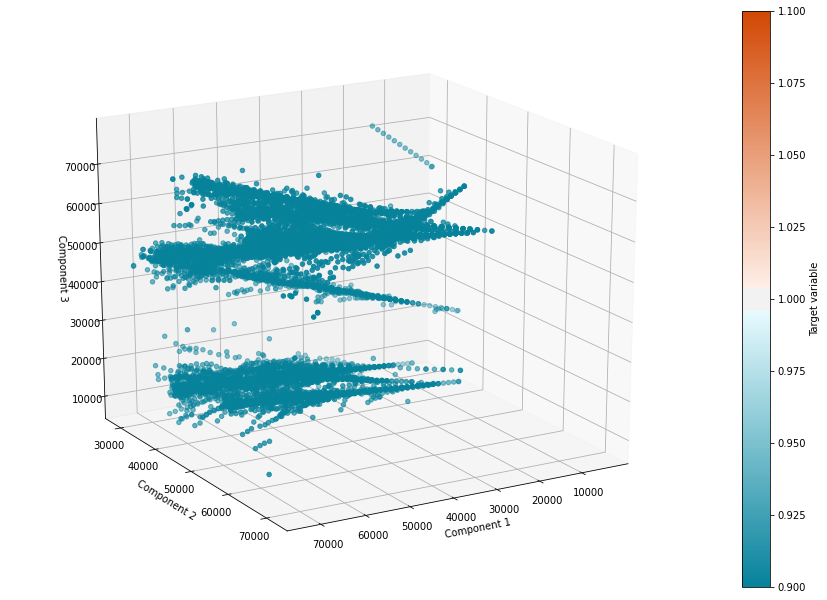

In [9]:
plot3D(first.loc[first.signal==1, ['Z', 'X', 'Y']].values,
       first.loc[first.signal==1].signal.values, elev=20, azim=60)

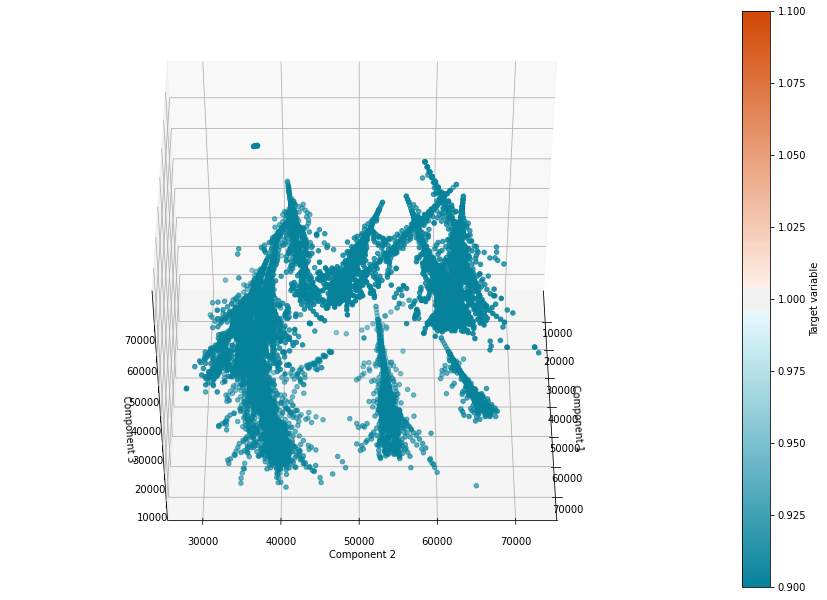

In [10]:
plot3D(first.loc[first.signal==1, ['Z', 'X', 'Y']].values,
       first.loc[first.signal==1].signal.values, elev=45, azim=0)

## Let's take a look at basetrack distribution along the axis

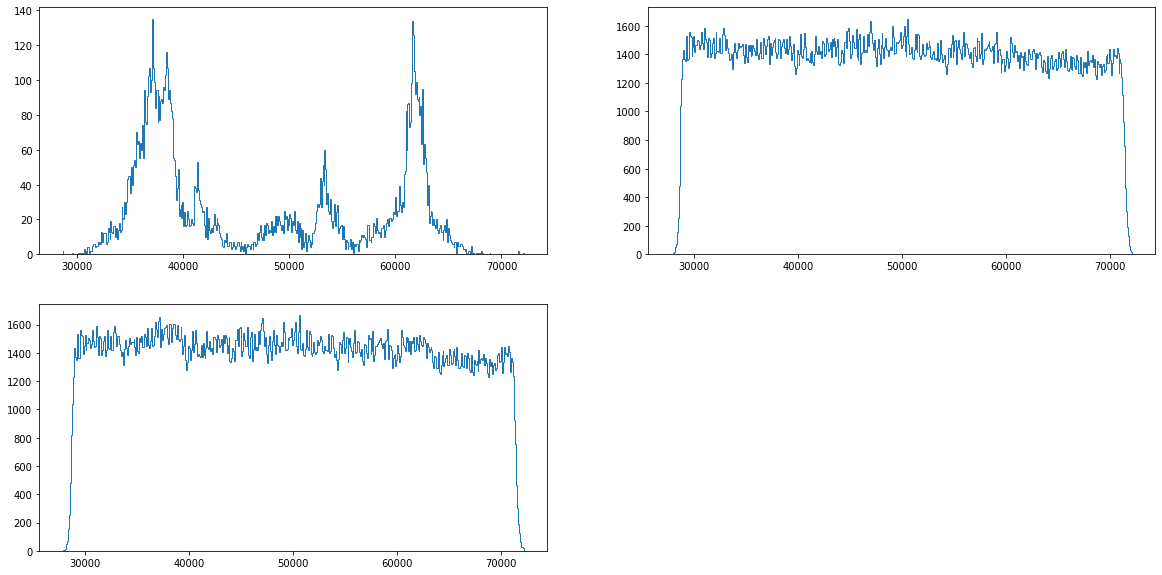

In [11]:
axis = 'X'

fig = plt.figure(figsize = [20, 10])
fig.add_subplot(221)
plt.hist(first.loc[first.signal == 1, axis], bins=500, histtype='step')
fig.add_subplot(222)
plt.hist(first.loc[first.signal == 0, axis], bins=500, histtype='step')
fig.add_subplot(223)
values_X = plt.hist(first.loc[:, axis], bins=500, histtype='step')
plt.show()

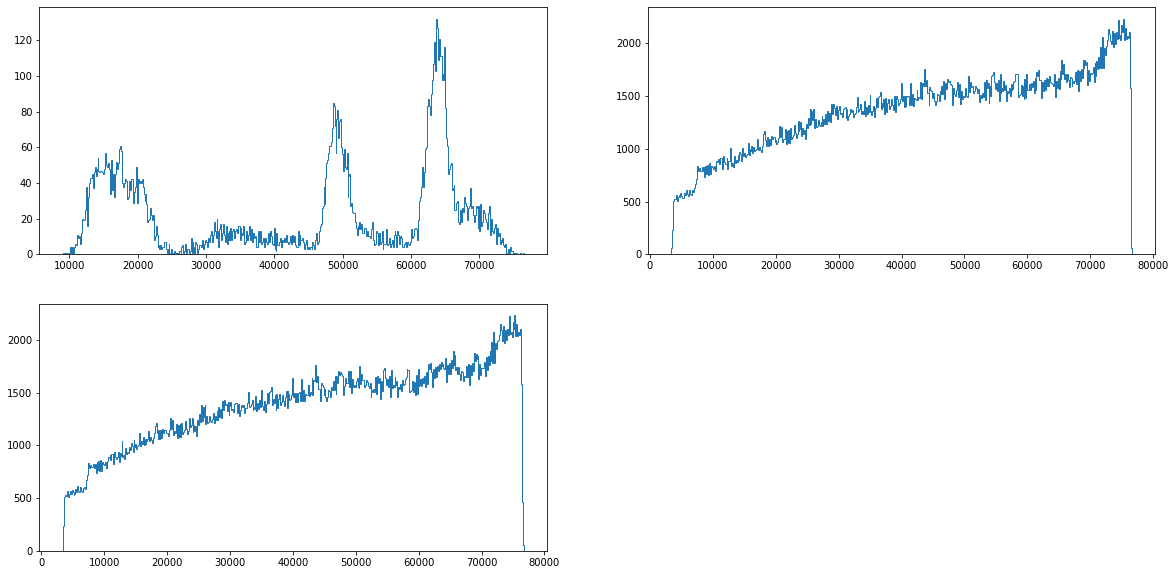

In [12]:
axis = 'Y'

fig = plt.figure(figsize = [20, 10])
fig.add_subplot(221)
plt.hist(first.loc[first.signal == 1, axis], bins=500, histtype='step')
fig.add_subplot(222)
plt.hist(first.loc[first.signal == 0, axis], bins=500, histtype='step')
fig.add_subplot(223)
values_X = plt.hist(first.loc[:, axis], bins=500, histtype='step')
plt.show()

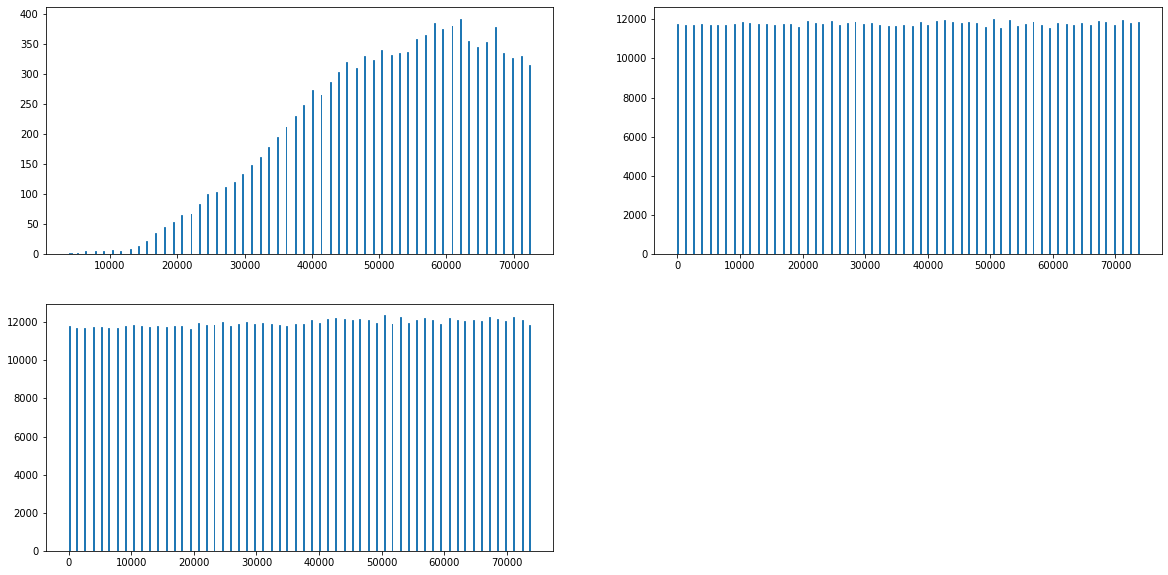

In [13]:
axis = 'Z'

fig = plt.figure(figsize = [20, 10])
fig.add_subplot(221)
plt.hist(first.loc[first.signal == 1, axis], bins=500, histtype='step')
fig.add_subplot(222)
plt.hist(first.loc[first.signal == 0, axis], bins=500, histtype='step')
fig.add_subplot(223)
values_X = plt.hist(first.loc[:, axis], bins=500, histtype='step')
plt.show()

# Grouping close tracks from neighbour plates into pairs

In [1]:
def add_neighbours(df, k, metric='minkowski'):
    res = []
    
    for data_ind in tqdm(np.unique(df.data_ind)):
        ind = df.loc[df.data_ind == data_ind].copy()
        # 1293 is the distance between slices in Z
        ind[['TX', 'TY']] *= 1293
        values = np.unique(ind.Z)
        
        for j in range(1, len(values)):
            z, z_next = (ind.loc[ind.Z == values[j-1]].copy(),
                         ind.loc[ind.Z == values[j]].copy())
            
            b_tree = BallTree(z_next[feat_XY], metric=metric)
            d, i = b_tree.query(z[feat_XY], k=min(k, len(z_next)))
            
            for m in range(i.shape[1]):
                data = z_next.iloc[i[:, m]]
                z_copy = z.copy()
                for col in feat_XY + ['Z']:
                    z_copy[col + '_pair'] = data[col].values
                res.append(z_copy)
            
        res.append(z_next)
        
    res = pd.concat(res, sort=True)
    for col in feat_XY + ['Z']:
        res['d' + col] = res[col].values - res[col + '_pair'].values
    return res

def balance_train(df, k):
    data = add_neighbours(df, k=k)
    noise = data.event_id == -999
    signal, not_signal = data.loc[np.logical_not(noise)], data.loc[noise]
    noise_part = not_signal.sample(len(signal))
    return pd.concat([signal, noise_part], sort=True).reset_index(drop=True)

In [15]:
train = []
for file in glob.glob('/content/drive/My Drive/week 4/open*.h5')[:5]: # just 5 bricks
    train.append(balance_train(pd.read_hdf(file), k=3))
train = pd.concat(train, sort=True)

100%|██████████| 10/10 [00:33<00:00,  3.33s/it]


In [16]:
train.head()

,TX,TX_pair,TY,TY_pair,X,X_pair,Y,Y_pair,Z,Z_pair,dTX,dTY,dX,dY,dZ,data_ind,event_id,signal
0,64.295792,85.199005,120.471031,128.525360,49545.425781,49540.316406,58027.636719,58018.058594,5172.000000,5427.205078,-20.903214,-8.054329,5.109375,9.578125,-255.205078,271,153997.0,1.0
1,85.199005,70.662689,128.525360,122.620712,49540.316406,49611.359375,58018.058594,58146.925781,5427.205078,6465.000000,14.536316,5.904648,-71.042969,-128.867188,-1037.794922,271,189715.0,1.0
2,85.199005,-117.009766,128.525360,153.375397,49540.316406,49843.593750,58018.058594,58355.070312,5427.205078,6465.000000,202.208771,-24.850037,-303.277344,-337.011719,-1037.794922,271,189715.0,1.0
3,85.199005,507.651611,128.525360,42.330360,49540.316406,50004.304688,58018.058594,58237.914062,5427.205078,6465.000000,-422.452606,86.195000,-463.988281,-219.855469,-1037.794922,271,189715.0,1.0
4,-1019.463440,-967.443237,-316.895508,-311.478729,60857.125000,60936.945312,34515.269531,34540.082031,6465.000000,6702.123047,-52.020203,-5.416779,-79.820312,-24.812500,-237.123047,271,183074.0,1.0


# Building a model

In [0]:
y_train = train.signal
X_train = train.drop(['event_id', 'signal', 'data_ind'], axis=1)

In [0]:
# import os

# mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-7.2.0-posix-seh-rt_v5-rev1\\mingw64\\bin'

# os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

import xgboost as xg
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV

In [0]:
param_grid = {
        'n_estimators':[10, 20], 
        'max_depth':[15],
}

class XGBClassifier_tmp(XGBClassifier):
    def predict(self, X):
        return XGBClassifier.predict_proba(self, X)[:, 1]

clf = GridSearchCV(XGBClassifier_tmp(learning_rate=0.05, subsample=0.8,
                                     colsample_bytree=0.8, n_jobs=20), 
                   param_grid=param_grid, n_jobs=1,
                   scoring='roc_auc',
                   cv=StratifiedKFold(2, shuffle=True, random_state=0),
                   verbose=7)

In [20]:
clf.fit(X_train, y_train)

Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] max_depth=15, n_estimators=10 ...................................
[CV] ....... max_depth=15, n_estimators=10, score=0.923, total= 3.4min
[CV] max_depth=15, n_estimators=10 ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.4min remaining:    0.0s


[CV] ....... max_depth=15, n_estimators=10, score=0.923, total= 3.3min
[CV] max_depth=15, n_estimators=20 ...................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  6.8min remaining:    0.0s


[CV] ....... max_depth=15, n_estimators=20, score=0.927, total= 6.5min
[CV] max_depth=15, n_estimators=20 ...................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 13.2min remaining:    0.0s


[CV] ....... max_depth=15, n_estimators=20, score=0.928, total= 6.3min


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 19.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 19.5min finished


[00:38:12] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=0, shuffle=True),
             error_score=nan,
             estimator=XGBClassifier_tmp(base_score=0.5, booster='gbtree',
                                         colsample_bylevel=1,
                                         colsample_bynode=1,
                                         colsample_bytree=0.8, gamma=0,
                                         learning_rate=0.05, max_delta_step=0,
                                         max_depth=3, min_child_weight=1,
                                         missing=None, n_estimators=100,
                                         n_jobs=20, nthread=None,
                                         objective='binary:logistic',
                                         random_state=0, reg_alpha=0,
                                         reg_lambda=1, scale_pos_weight=1,
                                         seed=None, silent=None, subsample=0.8,
                                      

In [21]:
clf.best_estimator_

XGBClassifier_tmp(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                  colsample_bynode=1, colsample_bytree=0.8, gamma=0,
                  learning_rate=0.05, max_delta_step=0, max_depth=15,
                  min_child_weight=1, missing=None, n_estimators=20, n_jobs=20,
                  nthread=None, objective='binary:logistic', random_state=0,
                  reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                  silent=None, subsample=0.8, verbosity=1)

In [0]:
xgb_class = clf.best_estimator_

# Deep Neural Network

In [0]:
from sklearn.preprocessing import Normalizer
transformer = Normalizer()
X_train_norm = transformer.fit_transform(X_train.fillna(0))

In [24]:
X_train_norm[:5]

array([[ 5.9445022e-04,  7.8771199e-04,  1.1138214e-03,  1.1882882e-03,
         4.5807493e-01,  4.5802769e-01,  5.3649765e-01,  5.3640908e-01,
         4.7818005e-02,  5.0177518e-02, -1.9326179e-04, -7.4466734e-05,
         4.7239002e-05,  8.8555076e-05, -2.3595123e-03],
       [ 7.8648684e-04,  6.5229955e-04,  1.1864399e-03,  1.1319331e-03,
         4.5731527e-01,  4.5797107e-01,  5.3557479e-01,  5.3676438e-01,
         5.0099473e-02,  5.9679538e-02,  1.3418726e-04,  5.4506829e-05,
        -6.5581000e-04, -1.1895954e-03, -9.5800655e-03],
       [ 7.8489695e-04, -1.0779540e-03,  1.1840415e-03,  1.4129728e-03,
         4.5639080e-01,  4.5918477e-01,  5.3449214e-01,  5.3759682e-01,
         4.9998198e-02,  5.9558894e-02,  1.8628510e-03, -2.2893128e-04,
        -2.7939465e-03, -3.1047249e-03, -9.5606996e-03],
       [ 7.8480330e-04,  4.6761888e-03,  1.1839003e-03,  3.8992247e-04,
         4.5633635e-01,  4.6061033e-01,  5.3442836e-01,  5.3645355e-01,
         4.9992230e-02,  5.9551790e-0

In [25]:
from keras.layers.core import Dense, Activation, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [0]:
def nn_model(input_dim):
    model = Sequential()
    model.add(Dense(256, input_dim=input_dim))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam())
    return model

In [0]:
callbacks = [EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto'),
            ModelCheckpoint('/content/drive/My Drive/week 4/output/{val_loss:.4f}.hdf5', monitor='val_loss', verbose=2, save_best_only=True, mode='auto')]

In [34]:
nn = nn_model(X_train_norm.shape[1])
nn.fit(X_train_norm, y_train, validation_split=0.2, epochs=10, verbose=2, batch_size=256, shuffle=True, callbacks=callbacks)

Train on 3863664 samples, validate on 965916 samples
Epoch 1/10
 - 53s - loss: 0.5697 - val_loss: 0.5789

Epoch 00001: val_loss improved from inf to 0.57889, saving model to /content/drive/My Drive/week 4/output/0.5789.hdf5
Epoch 2/10
 - 52s - loss: 0.5250 - val_loss: 0.5046

Epoch 00002: val_loss improved from 0.57889 to 0.50461, saving model to /content/drive/My Drive/week 4/output/0.5046.hdf5
Epoch 3/10
 - 52s - loss: 0.5023 - val_loss: 0.4867

Epoch 00003: val_loss improved from 0.50461 to 0.48673, saving model to /content/drive/My Drive/week 4/output/0.4867.hdf5
Epoch 4/10
 - 52s - loss: 0.4882 - val_loss: 0.4648

Epoch 00004: val_loss improved from 0.48673 to 0.46479, saving model to /content/drive/My Drive/week 4/output/0.4648.hdf5
Epoch 5/10
 - 52s - loss: 0.4757 - val_loss: 0.4636

Epoch 00005: val_loss improved from 0.46479 to 0.46364, saving model to /content/drive/My Drive/week 4/output/0.4636.hdf5
Epoch 6/10
 - 51s - loss: 0.4667 - val_loss: 0.4408

Epoch 00006: val_loss i

# Prediction

In [35]:
prepared_test = add_neighbours(test, k=3)
X_test = prepared_test.drop(['data_ind'], axis=1)

100%|██████████| 11/11 [00:37<00:00,  3.36s/it]


In [0]:
X_test_norm = transformer.transform(X_test.fillna(0))

In [37]:
X_test_norm[:5]

array([[-0.00300835, -0.00545834,  0.00972185,  0.00681656,  0.59126395,
         0.59333384,  0.3890069 ,  0.3820696 ,  0.        ,  0.02014557,
         0.00245   ,  0.00290529, -0.00206989,  0.00693733, -0.02014557],
       [-0.00252528, -0.00426304, -0.00411378,  0.00513677,  0.44063714,
         0.4414619 ,  0.5499566 ,  0.55488485,  0.        ,  0.01448405,
         0.00173776, -0.00925055, -0.00082474, -0.00492826, -0.01448405],
       [-0.00225754, -0.00130645,  0.00582741,  0.00499869,  0.40678105,
         0.4056811 ,  0.5793259 ,  0.57797784,  0.        ,  0.0101163 ,
        -0.00095108,  0.00082872,  0.00109993,  0.00134809, -0.0101163 ],
       [-0.00126105, -0.00467851, -0.00375272,  0.00103273,  0.2839596 ,
         0.28194952,  0.64870447,  0.6470427 ,  0.        ,  0.0124427 ,
         0.00341746, -0.00478544,  0.00201007,  0.00166179, -0.0124427 ],
       [-0.00162928,  0.00094605,  0.00400398,  0.00541683,  0.4728925 ,
         0.47000167,  0.5251422 ,  0.5286355 , 

In [0]:
probas = nn.predict_proba(X_test_norm)

In [39]:
print(probas.min())
print(probas.max())
print(probas.mean())

3.6890672e-16
0.9871458
0.24322072


In [40]:
probas.shape

(20179459, 1)

In [0]:
probas = np.squeeze(probas)

In [0]:
df = pd.DataFrame({'id': prepared_test.index, 'signal': probas}).groupby('id')
agg = df.aggregate(('mean')).loc[:, ['signal']]

In [43]:
agg.shape

(7698899, 1)

In [44]:
agg.head()

,signal
id,
0,0.288758
1,0.003774
2,0.237150
3,0.195068
4,0.004059
